<a href="https://colab.research.google.com/github/shahadalboti/JAAL/blob/main/jaal_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jaal:detecte wheelchairs in the masaá area in Mecca to prevent the entry of violators



## Outline
- [ 1- Libraries](#1)
- [ 2- CFG class](#2)
- [ 3- Dataset](#3)
  - [ 2.1  Visualize one image](#3.1)
  - [ 2.2  Visualize many images](#3.2)
  - [ 2.4  Visualize many images With the lable](#3.3)
  - [ 2.5  Dataset statistics](#3.4)

- [ 4- Model Implementation For Yolo V5](#4)
    - [ 4.1 Train](#4.1)
    - [ 4.2 Export](#4.2)
    - [ 4.3 Train results](#4.3)
    - [ 4.4 Validation results](#4.4)
    - [ 4.5 Inference](#4.5)
- [5 Faster Rcnn](#5)
- [ 6- Conclusion](#6)

<a name="1"></a>
# 1 - Libraries

First, let's run the cell below to import some required packages.
- [pandas](https://pandas.pydata.org/) a fast, powerful, flexible and easy to use open source data analysis and manipulation tools.
- [seaborn](https://seaborn.pydata.org/) a Python data visualization library for drawing attractive and informative statistical graphics.
- [numpy](https://numpy.org/) the core library for scientific computing in Python.
- [matplotlib](http://matplotlib.org) a popular library to plot graphs in Python.
- [time](https://docs.python.org/3/library/time.html) a library that provides various time-related functions.
- [pickle](https://docs.python.org/3/library/pickle.html) a library that converts a Python object into a byte stream to store it in a file/database, maintain program state across sessions, or transport data over the network.

In [1]:
# clone the repo
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15990, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15990 (delta 15), reused 16 (delta 11), pack-reused 15967
Receiving objects: 100% (15990/15990), 14.64 MiB | 15.19 MiB/s, done.
Resolving deltas: 100% (10977/10977), done.


In [2]:
# install dependencies
!pip install -qr yolov5/requirements.txt
%cd yolov5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.0/618.0 kB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00
/content/yolov5


In [3]:
! pip install --upgrade ultralytics -qq

In [4]:
import torch
import ultralytics
# to display image
from IPython.display import Image, clear_output
clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
import warnings
warnings.filterwarnings("ignore")
import os
import re
import glob
import random
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import IPython.display as display
from PIL import Image
import cv2
from ultralytics import YOLO

Setup complete. Using torch 2.0.1+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a name="2"></a>
## 2-CFG CLASS
CFG class enables easy and organized experimentation


In [6]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = ['Wheelchiers', 'People', 'NotWheelchier']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 20
    BATCH_SIZE = 16

    BASE_MODEL = 'yolov5s'
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'jaal_{EPOCHS}_epochs'

    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    CUSTOM_DATASET_DIR = '/content/drive/MyDrive/archive'
    OUTPUT_DIR = './'

<a name="3"></a>
## 3- Dataset

Start by reading the dataset for this code.
- The dataset contains images labeled as 0=person or 1=Wheelchier or
 2 = Not Wheelchier.

- The data set contains 1255 images and 1255 lable for each image, dataset split into tein, test and validate

<a name="3.1"></a>
###3.1 Visualize one image

In [7]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

<a name="3.2"></a>
###3.2 Visualize many images


In [10]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

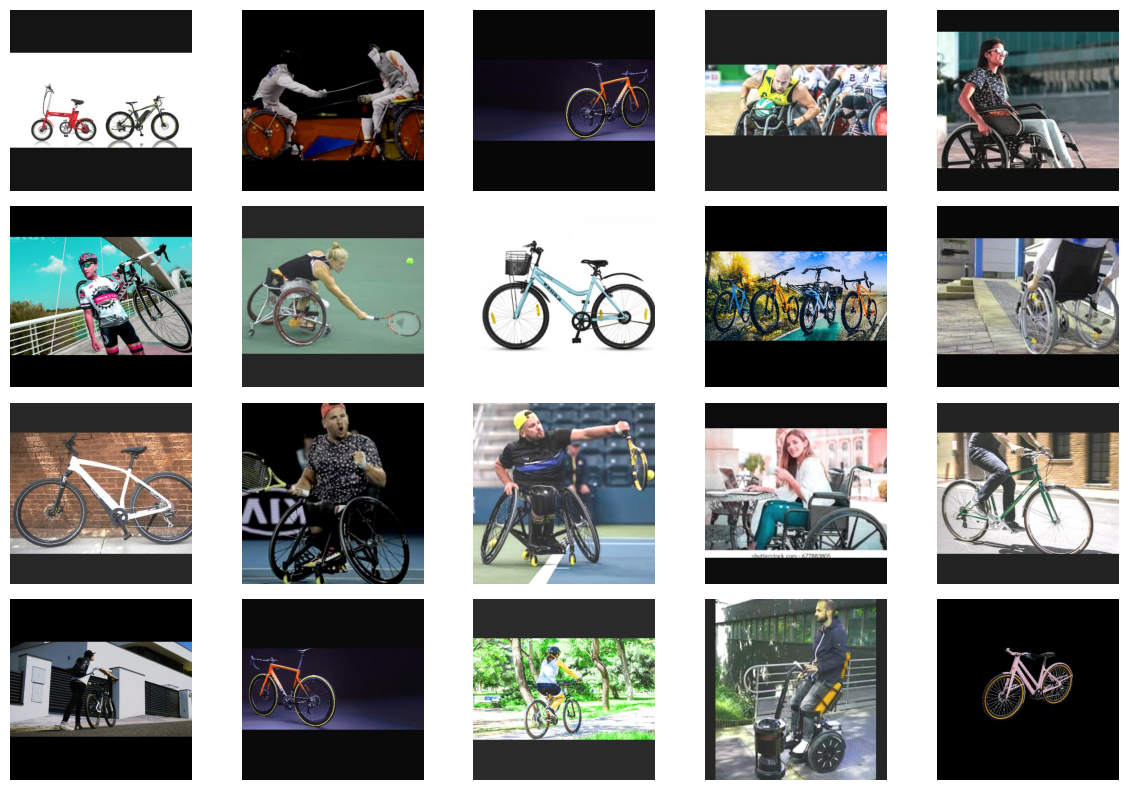

In [11]:
folder_path = CFG.CUSTOM_DATASET_DIR + '/train/images'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)
# plot_random_images_from_folder(folder_path, num_images=20, seed=54)

<a name="3.3"></a>
###3.3 Visualize many images With the lable

In [12]:
train_images = "/content/drive/MyDrive/archive/train/images"
train_labels = "/content/drive/MyDrive/archive/train/labels"

val_images='/content/drive/MyDrive/archive/valid/images'
val_labels='/content/drive/MyDrive/archive/valid/labels'

test_images = "/content/drive/MyDrive/archive/test/images"
test_labels = "/content/drive/MyDrive/archive/test/labels"

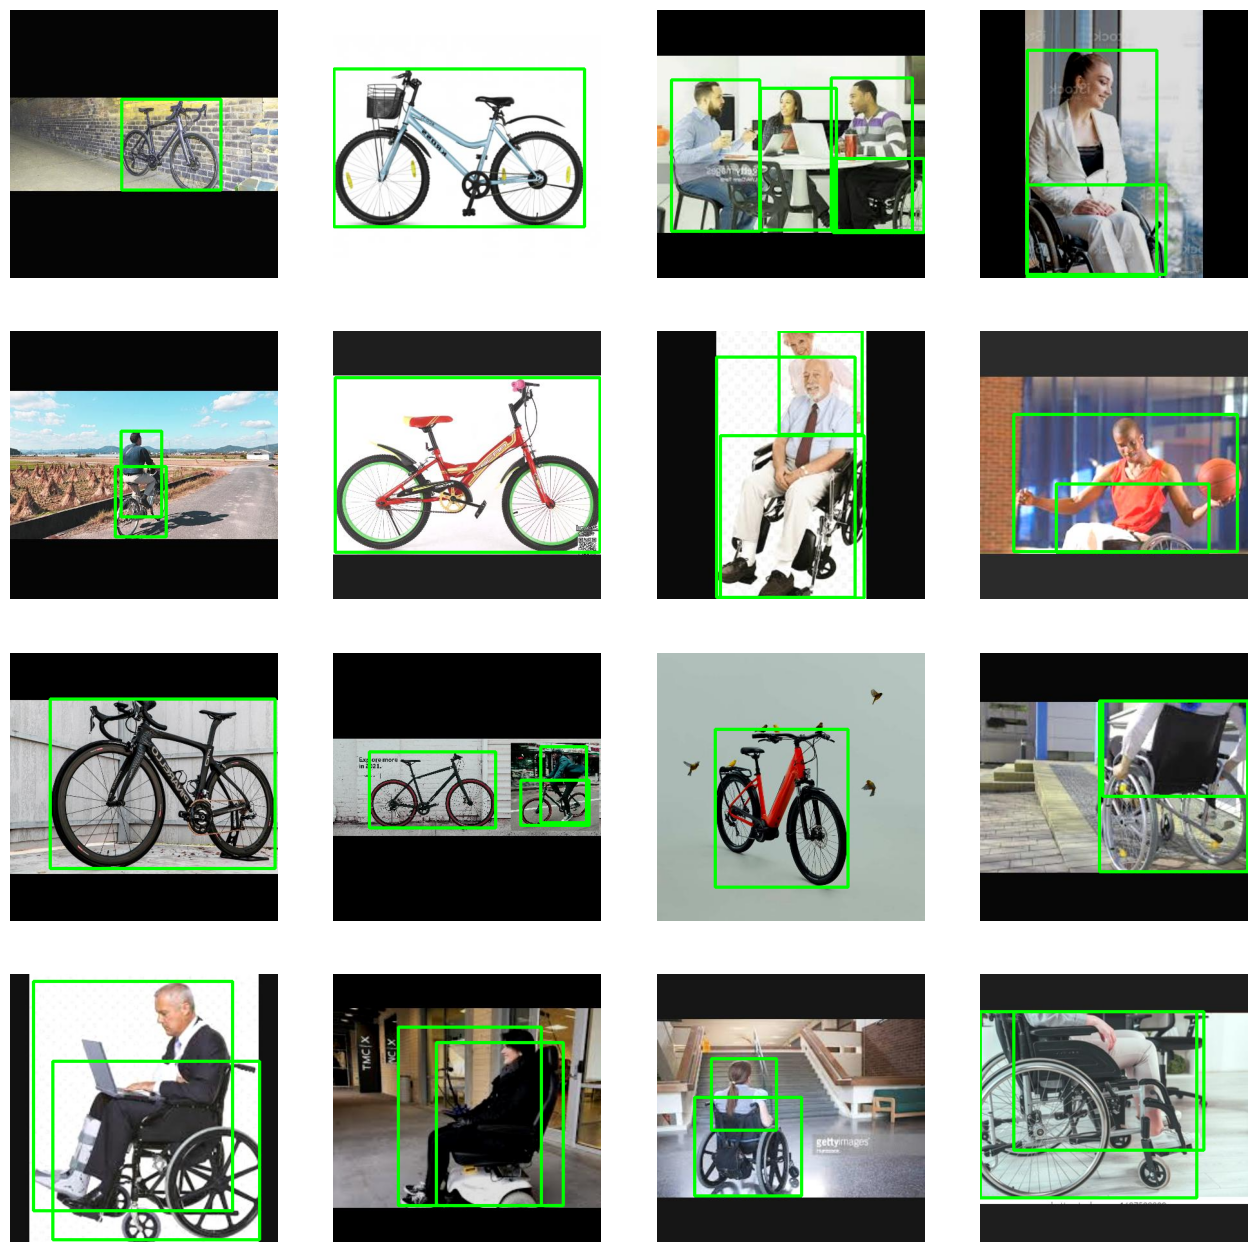

In [ ]:
# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4

    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

In [13]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [14]:
img_properties = get_image_properties('/content/drive/MyDrive/archive/train/images/100_png.rf.5eed53ba06ea9a336243ba666c65f01d.jpg')
img_properties

{'width': 416, 'height': 416, 'channels': 3, 'dtype': dtype('uint8')}

<a name="3.4"></a>
###3.4 Dataset statistics

In [15]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 216 ms, sys: 125 ms, total: 340 ms
Wall time: 29.1 s


,Mode,Wheelchiers,People,NotWheelchier,Data_Volume
0,train,879,759,351,1107
1,valid,88,74,33,107
2,test,0,0,0,0


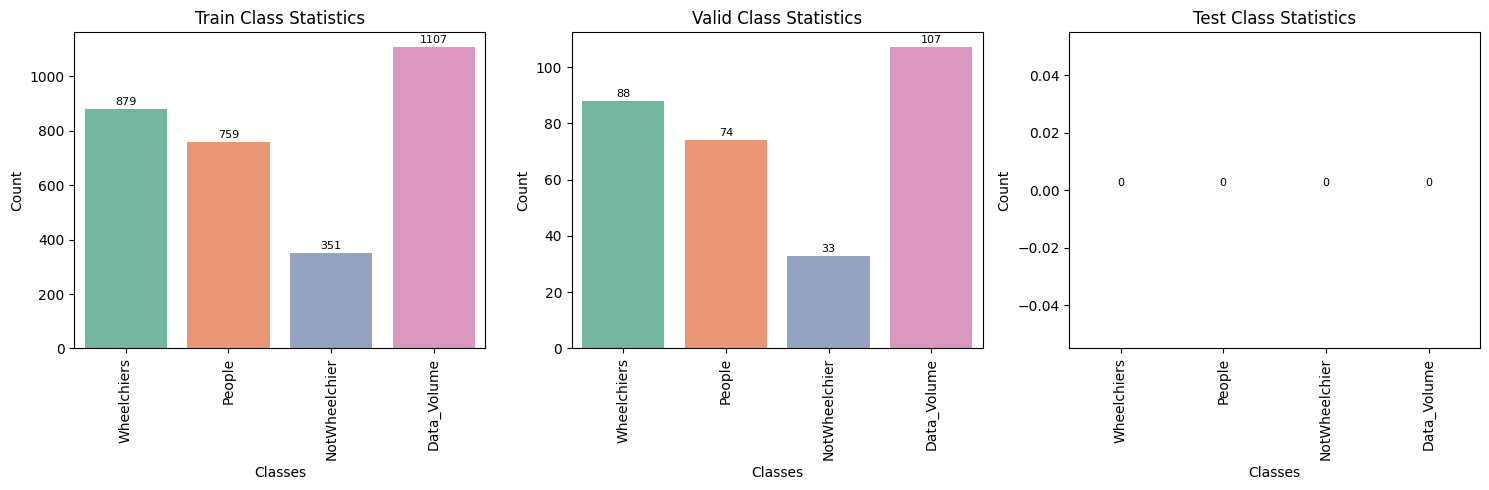

In [16]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

In [17]:
%%time

for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(416, 416)



Image sizes in valid set:
(416, 416)



Image sizes in test set:
(316, 160)


(275, 183)


(274, 182)


(372, 248)


(274, 182)


(900, 600)


(274, 182)


(278, 180)


(274, 182)


(1120, 630)


(900, 599)


(900, 600)


(1120, 747)


CPU times: user 208 ms, sys: 86.5 ms, total: 294 ms
Wall time: 14.4 s


<a name="4"></a>
## 4 - Model Implementation for YoloV5

Various Deep learning methods can be applied to detect wheechiers. In this notebook we will train Yolo v5 and Faster R-CNN models. to detect wheelchiers in the Masaa.

In [19]:
# checking the power of the pretrained model inference on the wheelchiers detection
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source ='/content/drive/MyDrive/archive/train/images/104_png.rf.ad5887cf8824c357335bffa244e3ff4f.jpg',

    classes = [0],
    conf = 0.30,
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


image 1/1 /content/drive/MyDrive/archive/train/images/104_png.rf.ad5887cf8824c357335bffa244e3ff4f.jpg: 416x416 2 persons, 17.4ms
Speed: 5.3ms preprocess, 17.4ms inference, 42.3ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


<a name="4.1"></a>
###4.1 Train the model

In [20]:
#Traning HyperPramiter
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov5s.pt
Epochs:  20
Batch:  16


In [21]:
#Load the pre-trained model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



In [39]:
#REtrain the model
%%time

### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, '/content/drive/MyDrive/archive/data.yaml'),
    task = 'detect',
    imgsz = (img_properties['height'], img_properties['width']),
    epochs = 200,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,
    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,
    cache = True,
    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    verbose = False,
)

TypeError: ignored

<a name="4.2"></a>
###4.2 Export

Export mode is used for exporting a YOLOv8 model to a format that can be used for deployment. In this mode, the model is converted to a format that can be used by other software applications or hardware devices. This mode is useful when deploying the model to production environments.

In [24]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.0.182 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
YOLOv5s summary (fused): 193 layers, 9112697 parameters, 0 gradients, 23.8 GFLOPs

PyTorch: starting from 'runs/detect/yolov5s_jaal_20_epochs/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 7, 3549) (17.6 MB)

ONNX: starting export with onnx 1.14.1 opset 17...
ONNX: export success ✅ 1.3s, saved as 'runs/detect/yolov5s_jaal_20_epochs/weights/best.onnx' (34.9 MB)

Export complete (3.4s)
Results saved to /content/yolov5/runs/detect/yolov5s_jaal_20_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov5s_jaal_20_epochs/weights/best.onnx imgsz=416  
Validate:        yolo val task=detect model=runs/detect/yolov5s_jaal_20_epochs/weights/best.onnx imgsz=416 data=/content/drive/MyDrive/archive/data.yaml  
Visualize:       https://netron.app


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



'runs/detect/yolov5s_jaal_20_epochs/weights/best.onnx'

<a name="4.3"></a>
### 4.3 Train results

In [25]:
results_paths = [
    i for i in
    glob.glob('/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/*.png') +
    glob.glob('/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/*.jpg')
    if 'batch' not in i
]

results_paths

['/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/results.png',
 '/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/PR_curve.png',
 '/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/confusion_matrix.png',
 '/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/P_curve.png',
 '/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/confusion_matrix_normalized.png',
 '/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/R_curve.png',
 '/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/F1_curve.png',
 '/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/labels_correlogram.jpg',
 '/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/labels.jpg']

/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/F1_curve.png


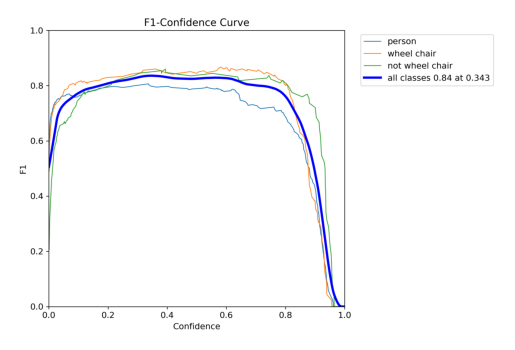



/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/PR_curve.png


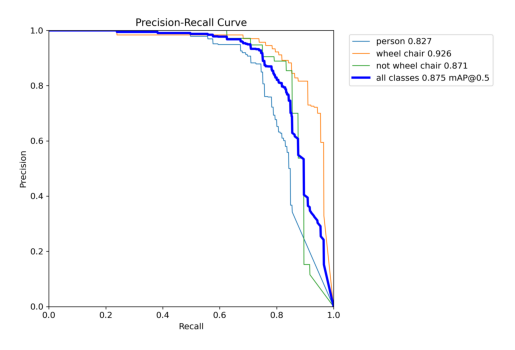



/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/P_curve.png


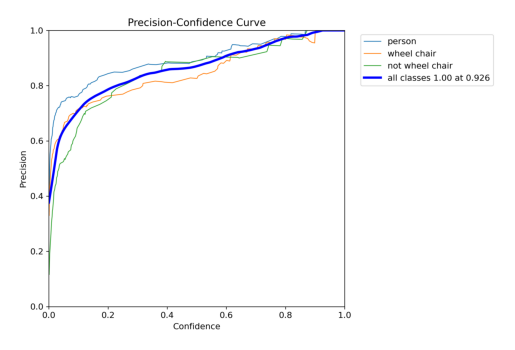



/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/R_curve.png


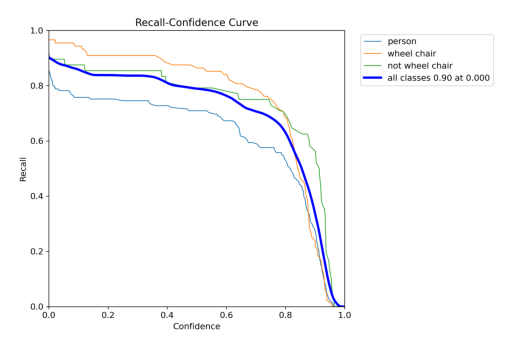



/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/confusion_matrix.png


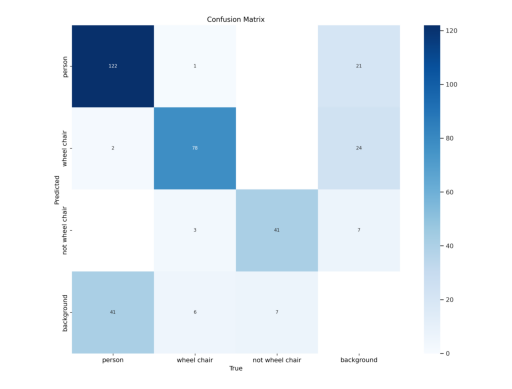



/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/confusion_matrix_normalized.png


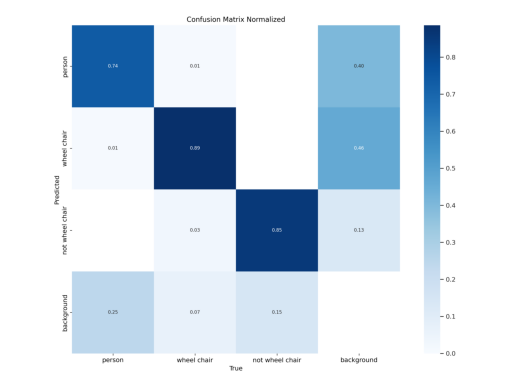



/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/labels.jpg


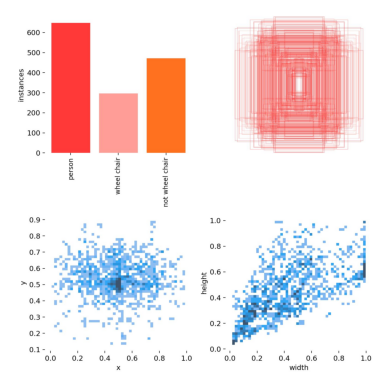



/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/labels_correlogram.jpg


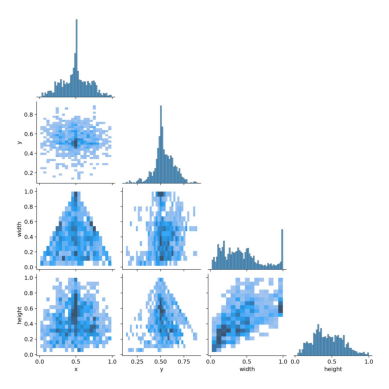



/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/results.png


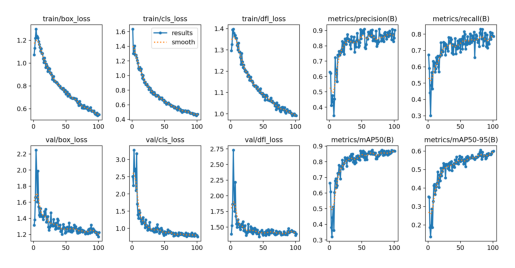

In [26]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

In [27]:
df = pd.read_csv('/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.07140,1.63650,1.29610,0.62933,0.67341,0.66415,0.35273,1.3156,2.50520,1.3859,0.000463,0.000463,0.000463
1,2,1.13070,1.30080,1.32550,0.62082,0.59045,0.60742,0.34952,1.3823,2.24450,1.5244,0.000935,0.000935,0.000935
2,3,1.21820,1.33820,1.39450,0.41042,0.44019,0.37903,0.18659,1.6598,3.27360,1.8647,0.001402,0.001402,0.001402
3,4,1.29810,1.40390,1.39820,0.43498,0.30057,0.32036,0.13607,2.2482,2.67090,2.7300,0.001408,0.001408,0.001408
4,5,1.23670,1.28010,1.37780,0.47580,0.48624,0.44344,0.19648,1.9718,2.72440,2.1179,0.001408,0.001408,0.001408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,97,0.54767,0.46495,0.99531,0.90748,0.76901,0.86695,0.58066,1.2306,0.84501,1.4267,0.000757,0.000757,0.000757
97,98,0.56360,0.46874,0.99967,0.87553,0.78705,0.86788,0.58611,1.1996,0.81434,1.4155,0.000750,0.000750,0.000750
98,99,0.53962,0.45044,0.99264,0.82816,0.80694,0.86892,0.59638,1.1968,0.80107,1.4157,0.000743,0.000743,0.000743
99,100,0.55065,0.46617,0.99302,0.85115,0.78914,0.86970,0.59802,1.1712,0.78855,1.3671,0.000736,0.000736,0.000736


In [28]:
print('*'*50)
print('\nBest Training loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('*'*50)
print('\nBest Validation loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')
print('*'*50)

**************************************************

Best Training loss:  0.53962 , on epoch:  99 

**************************************************

Best Validation loss:  1.1712 , on epoch:  100 

**************************************************


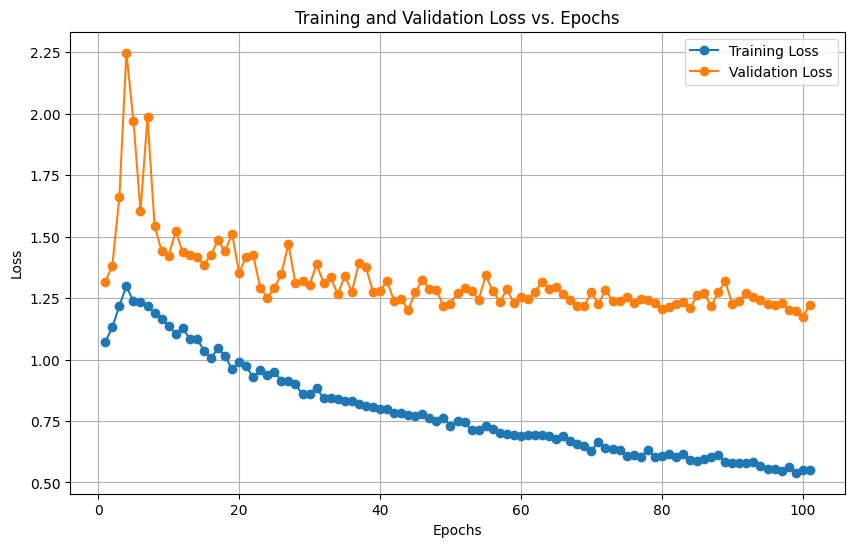

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['train/box_loss'], label='Training Loss', marker='o', linestyle='-')
plt.plot(df['epoch'], df['val/box_loss'], label='Validation Loss', marker='o', linestyle='-')

plt.title('Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()

<a name="4.4"></a>
###4.4 Validation results

In [30]:
validation_results_paths = [
    i for i in
    glob.glob('/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/*.png') +
    glob.glob('/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [31]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/val_batch2_labels.jpg


/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/val_batch1_pred.jpg


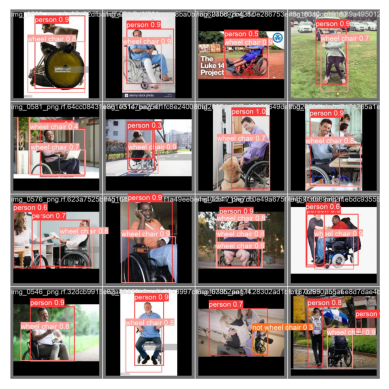

In [32]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)

<a name="4.5"></a>
###4.5 Inference

In [35]:
model = YOLO('/content/yolov5/runs/detect/yolov5s_jaal_20_epochs/weights/best.onnx')
model.predict(
    source= '/content/drive/MyDrive/archive/test/images/*',
    task = 'predicrt',
    imgsz = (img_properties['height'], img_properties['width']),
     batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,
    name = 'predict',
    seed = CFG.SEED,
    cache = True,
    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    verbose = False,
    save= True,
)

Loading /content/yolov5/runs/detect/yolov5s_jaal_20_epochs/weights/best.onnx for ONNX Runtime inference...
requirements: Ultralytics requirement ['onnxruntime'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 181.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 245.5 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 5.8s, installed 1 package: ['onnxruntime']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

Results saved to runs/predicrt/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'wheel chair', 2: 'not wheel chair'}
 orig_img: array([[[140, 157, 154],
         [139, 156, 153],
         [137, 154, 151],
         ...,
         [190, 211, 209],
         [189, 210, 208],
         [189, 210, 208]],
 
        [[142, 159, 156],
         [141, 158, 155],
         [140, 157, 154],
         ...,
         [177, 198, 196],
         [179, 200, 198],
         [181, 202, 200]],
 
        [[145, 162, 159],
         [144, 161, 158],
         [143, 160, 157],
         ...,
         [187, 208, 209],
         [190, 211, 212],
         [191, 212, 213]],
 
        ...,
 
        [[156, 165, 162],
         [163, 172, 169],
         [169, 178, 175],
         ...,
         [204, 213, 210],
         [196, 205, 202],
         [192, 201, 198]],
 
        [[169, 178, 175],
         [170, 179, 176],
         [169, 178, 175],
   

In [36]:
# Check the lable detected in the model
model.names

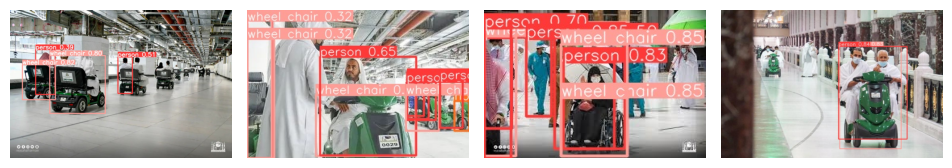

In [38]:
#Plot the resault of the Inference
folder_path = '/content/yolov5/runs/predicrt/predict'
plot_random_images_from_folder(folder_path, num_images=4)

<a name="5"></a>
# 5 Faster R-CNN


<a name="6"></a>
# 6- Conclusion

After the methods are evaluated using the evaluation metrics:
